In [249]:
using Clapeyron, PyCall, LaTeXStrings, LinearAlgebra, GenericLinearAlgebra, CSV, Tables, ForwardDiff

import PyPlot; plt = PyPlot

PyPlot

In [384]:
rcParams = PyDict(plt.matplotlib["rcParams"])

WIDTH = 1.5 * 8.3 / 2.54
DOUBLE_WIDTH = 1.5 * 17.1 / 2.54
DPI = 150
rcParams["axes.labelsize"]= 14
rcParams["axes.xmargin"]= 0
rcParams["axes.ymargin"]= .1
rcParams["lines.markersize"]= 5
rcParams["figure.dpi"]= DPI
rcParams["figure.autolayout"]= true
rcParams["figure.figsize"]= (WIDTH, 3 * WIDTH / 4)
rcParams["figure.facecolor"]= "white"
rcParams["font.size"]= 12
rcParams["grid.color"]= "0"
rcParams["grid.linestyle"]= "-"
rcParams["legend.edgecolor"]= "1"
rcParams["legend.fontsize"]= 10
rcParams["xtick.labelsize"]= 12
rcParams["ytick.labelsize"]= 12
rcParams["xtick.direction"]= "in"
rcParams["ytick.direction"]= "in"
rcParams["font.family"]= "sans-serif"
rcParams["font.sans-serif"]= ["Arial"]
# Create color wheel
rcParams["axes.prop_cycle"] = plt.matplotlib.cycler(color=["#4063D8","#009B72","#FFB400","#D80032","#9558B2","#01172F"])

'#4063D8'
'#009B72'
'#FFB400'
'#D80032'
'#9558B2'
'#01172F'


In [229]:
include("Helmholtz_LS.jl")

norm(x) = sqrt(x'x)

norm (generic function with 1 method)

# Neutral Polyampholytes

In [295]:
function critObj_mix(F,model,lB,ρ)
    ncomps = length(model)
    N = model.params.N.values
    Z = model.params.Z.values
    ν = abs(Z[1]/Z[2])

    fun(x) = a(model,lB,[x[1],x[1]/N[1]*ν+x[2],x[2]])
    Hf(x) = Clapeyron.ForwardDiff.hessian(fun,x)
    Lf(x) = det(Symmetric(Hf(x)))
    dLf(x) = Clapeyron.ForwardDiff.gradient(Lf,x)
    HH = Hf(ρ)
    LL = det(HH)
    M = [HH[1:end-1,:];transpose(dLf(ρ))]
    
    F[1] = -LL
    F[2] = -det(M)
    return F
end

function phaseqObj(F,model,lB,ρ0,ρsup,ρco,ϕ,ψ)
    ncomps = length(model)
    N = model.params.N.values
    Z = model.params.Z.values
    fun(x) = a(model,lB,x)
    df(x) = Clapeyron.ForwardDiff.gradient(fun,x)
    
    μsup = df(ρsup)
    μco  = df(ρco)
    
    F[1:ncomps] = @. (μsup-μco)-ψ*Z/N
    F[ncomps+1:2*ncomps] = (1-ϕ).*ρco + ϕ.*ρsup .- ρ0   
    
    F[2*ncomps+1] = -fun(ρsup)+fun(ρco)-sum(μco.*ρco)+sum(μsup.*ρsup)-ψ*sum(Z./N.*ρsup)
    F[2*ncomps+2] = sum(ρsup.*Z./N)
    # Add mass balance
     
    return F
end

function phaseqObj_pure(F,model,lB,ρsup,ρco)

    fun(x)  = a(model,lB,[x[1]])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    
    μsup = df(ρsup)
    μco  = df(ρco)
    
    F[1] = (μsup.-μco)
    
    F[2] = (fun(ρsup)-fun(ρco)+μco[1]*ρco[1]-μsup[1]*ρsup[1])
    # Add mass balance
    return F
end

function phaseqObj_pure_chrg(F,model,lB,ρsup,ρco)
    Z = model.params.Z.values
    N = model.params.N.values
    ν = abs(Z[1]/Z[2])

    fun(x)  = a(model,lB,[x[1],x[1]/N[1]*ν])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    
    μsup = df(ρsup)
    μco  = df(ρco)
    
    F[1] = (μsup.-μco)
    
    F[2] = (fun(ρsup)-fun(ρco)+μco[1]*ρco[1]-μsup[1]*ρsup[1])
    # Add mass balance
    return F
end

phaseqObj_pure_chrg (generic function with 1 method)

# Neutral Chain

In [230]:
lB = 1.
Nu = 1:10:60
N = 100
ρ = zeros(length(Nu),1000,6)

for j in 1:length(Nu)
    println("Nu = ",Nu[j])
    # Pure system
    x0 = [-30,-0.8]

    model = LS(["PAL"]; userlocations=(;
                        N = [N],
                        Nu = [Nu[j]],
                        Z = [0]))

    obj!(F,x) = phaseqObj_pure(F,model,lB,exp10(x[1]),exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
    x0 = Clapeyron.Solvers.x_sol(x)

    # PAL+salts
    model = LS(["PAL","C","A"]; userlocations=(;
                        N = [N,1,1],
                        Nu = [Nu[j],0,0],
                        Z = [0,1,-1]))

    ρ[j,1,[1,4]] = exp10.(x0)

    ρ0 = zeros(3)
    ρ0[1] = sum(ρ[j,1,[1,3]])/2
    ρ0[2:3] .= 1e-4
    x0 = [x0[1],-4.,-4.,x0[2],-4.,-4.,log10(0.5),0.]

    for i in 2:1000
        if mod(i,10)==0
            println("i = ",i)
        end
        obj!(F,x) = phaseqObj(F,model,lB,ρ0,exp10.(x[1:3]),exp10.(x[4:6]),exp10(x[7]),x[8])
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,i,:] = exp10.(x0[1:6])
        ρ0 = (ρ[j,i,1:3]+ρ[j,i,4:6])/2
        ρ0[2:3] .+= 1e-4
        if norm(ρ[j,i,1:3]-ρ[j,i,4:6])<1e-4
            break
        end
    end
end

# x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
# x0 = Clapeyron.Solvers.x_sol(x)

# ρ[2,:] = exp10.(x0[1:6])

Nu = 1
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
i = 100
i = 110
i = 120
i = 130
i = 140
i = 150
i = 160
i = 170
i = 180
i = 190
i = 200
i = 210
i = 220
i = 230
i = 240
i = 250
i = 260
i = 270
i = 280
i = 290
i = 300
i = 310
i = 320
i = 330
i = 340
i = 350
i = 360
i = 370
i = 380
i = 390
i = 400
Nu = 11
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
i = 100
i = 110
i = 120
i = 130
i = 140
i = 150
i = 160
i = 170
i = 180
i = 190
i = 200
i = 210
i = 220
i = 230
i = 240
i = 250
i = 260
i = 270
i = 280
i = 290
i = 300
i = 310
i = 320
i = 330
i = 340
Nu = 21
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
i = 100
i = 110
i = 120
i = 130
i = 140
i = 150
i = 160
i = 170
i = 180
i = 190
i = 200
i = 210
i = 220
i = 230
i = 240
i = 250
i = 260
i = 270
Nu = 31
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
i = 100
i = 110
i = 120
i = 130
i = 140
i = 150
i = 160
i = 170
i = 180
i = 190
i = 200
Nu = 41
i = 10
i = 20
i = 30
i = 40
i

InterruptException: InterruptException:

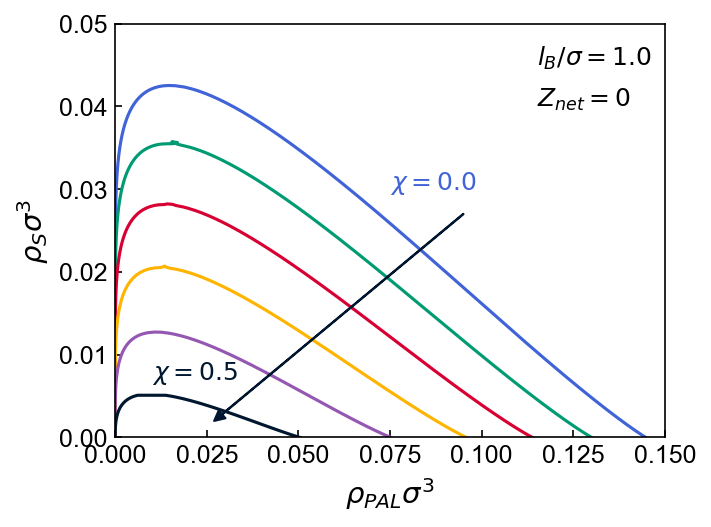

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [231]:
plt.clf()
for j in 1:length(Nu)
    idxend = findfirst(ρ[j,:,1].==0)-2
    X = vcat(ρ[j,1:idxend,1],reverse(ρ[j,1:idxend,4]))
    Y = vcat(ρ[j,1:idxend,2],reverse(ρ[j,1:idxend,5]))
    plt.plot(X,Y,label="Nu = $(Nu[j])")
end
plt.text(0.115,0.045,L"l_B/\sigma=1.0",fontsize=12)
plt.text(0.115,0.04,L"Z_{net}=0",fontsize=12)
plt.text(0.075,0.03,L"\chi=0.0",color="C0")
plt.text(0.01,0.007,L"\chi=0.5",color="C5")
plt.annotate("", xy=(0.027, 0.002), xytext=(0.095, 0.027), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))

plt.xlabel(L"\rho_{PAL}\sigma^3")
plt.ylabel(L"\rho_{S}\sigma^3")
plt.xlim(0,0.15)
plt.ylim(0,0.05)
plt.savefig("figures/phaseq_neut_salt.pdf",dpi=DPI)
plt.savefig("figures/phaseq_neut_salt.png",dpi=DPI)

display(plt.gcf())

In [235]:
for j in 1:length(Nu)
    # idxend = findfirst(ρ[j,:,1].==0)-2
    # X = vcat(ρ[j,1:idxend,1],reverse(ρ[j,1:idxend,4]))
    # Y = vcat(ρ[j,1:idxend,2],reverse(ρ[j,1:idxend,5]))
    CSV.write("data/pals_Nu_$(Nu[j])_Znet_0_salt.csv",  Tables.table(ρ[j,:,:]), writeheader=false)
end

# Charged Chains

In [1157]:
Np = 400
lB = 1.
Znet = -11:-2:-36
N = 100
Nu = 1
# ρ = zeros(length(Znet),1000,6)
ρU = CSV.read("data/pals_crit_salt_UCST.csv",Tables.matrix, header=false)
ρL = CSV.read("data/pals_crit_salt_LCST.csv",Tables.matrix, header=false)

ρ = zeros(length(Znet),Np,6)

for j in 1:1
    println("Znet = ",Znet[j])

    ρu = ρU[ρU[:,1].==Nu .&& ρU[:,2].==Znet[j],3:4]
    ρl = ρL[ρL[:,1].==Nu .&& ρL[:,2].==Znet[j],3:4]
    dρs = (ρu[2]-ρl[2])/Np
    println("dρs = ",dρs)

    if ρl[1] .== 0
        println("System doesn't have an LCST and is open at the bottom.")
        # Pure system
        x0 = [-3,-1.5]

        model = LS(["PAL","C"]; userlocations=(;
                            N = [N,1],
                            Nu = [Nu,0],
                            Z = [Znet[j],1]))

        obj!(F,x) = phaseqObj_pure_chrg(F,model,lB,exp10(x[1]),exp10(x[2]))
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,1,[1,4]] .= exp10.(x0)
        ρ[j,1,[2,5]] .= exp10.(x0).*abs(Znet[j])/N

        ρ0 = zeros(3)
        ρ0[1] = sum(ρ[j,1,[1,4]])/2
        ρ0[2] = sum(ρ[j,1,[2,5]])/2+dρs
        ρ0[3] = dρs
        x0 = [x0[1],log10(ρ[j,1,2]+dρs),log10(dρs),x0[2],log10(ρ[j,1,5]+dρs),log10(dρs),log10(0.5),0.]
    else
        println("System has an LCST.")
        ρ[j,1,1] = ρl[1]
        ρ[j,1,2] = ρl[1]/model.params.N[1]*abs(model.params.Z[1])+ρl[2]
        ρ[j,1,3] = ρl[2]
        ρ[j,1,4:6] .= ρ[j,1,1:3]

        ρ0 = deepcopy(ρ[j,1,1:3])
        ρ0[2:3] .+= dρs

        ϕ = 0.3
        f = 0.1
        g = (1-f+f*ϕ)/ϕ

        # x0 = vcat(ρ[j,1,1:3].*f,ρ[j,1,4:6].*g)
        # x0[2:3] .+= dρs
        # x0[5:6] .+= dρs
        # x0 = vcat(log10.(x0),[log10(ϕ)],[0.])

        x0 = [-10, log10(1e-10/N*abs(Znet[j])+dρs), log10(dρs), -1.5, log10(exp10(-1.5)/N*abs(Znet[j])+dρs), log10(dρs), log10(ϕ), 0.]
        
    end

    # PAL+salts
    model = LS(["PAL","C","A"]; userlocations=(;
                        N = [N,1,1],
                        Nu = [Nu,0,0],
                        Z = [Znet[j],1,-1]))

    for i in 2:Np
        if mod(i,10)==0
            println("i = ",i)
        end
        obj!(F,x) = phaseqObj(F,model,lB,ρ0,exp10.(x[1:3]),exp10.(x[4:6]),exp10(x[7]),x[8])
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,i,:] = exp10.(x0[1:6])
        ρ0 = (ρ[j,i,1:3]+ρ[j,i,4:6])/2
        ρ0[2:3] .+= dρs
        # if norm(ρ[j,i,1:3]-ρ[j,i,4:6])<1e-4
        #     break
        # end
    end
end

Znet = -11
dρs = 9.68103668039158e-5
System doesn't have an LCST and is open at the bottom.
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
i = 100
i = 110
i = 120
i = 130
i = 140
i = 150
i = 160
i = 170
i = 180
i = 190
i = 200
i = 210
i = 220
i = 230
i = 240
i = 250
i = 260
i = 270
i = 280
i = 290
i = 300
i = 310
i = 320
i = 330
i = 340
i = 350
i = 360
i = 370
i = 380


InterruptException: InterruptException:

In [1154]:
x

Results of solving non-linear equations

* Algorithm:
  Newton's method with default linsolve with Trust Region (Newton, eigen)

* Candidate solution:
  Final residual 2-norm:      8.81e-12
  Final residual Inf-norm:    7.96e-12

  Initial residual 2-norm:    7.83e-04
  Initial residual Inf-norm:  7.60e-04

* Stopping criteria
  |F(x')|               = 7.96e-12 <= 1.00e-08 (true)

* Work counters
  Seconds run:   1.71e-02
  Iterations:    3


In [1162]:
ρ[1,:,:]

400×6 Matrix{Float64}:
 0.042092   0.00463012  0.0          0.00103183   0.000113501  0.0
 0.0475677  0.00524306  6.81194e-6   7.57604e-10  0.000155775  0.000174938
 0.0517381  0.00571392  2.27237e-5   1.4077e-11   0.000313823  0.000328037
 0.0549543  0.0060891   4.4125e-5    3.01311e-12  0.000461609  0.000475037
 0.0575675  0.00640232  6.9896e-5    1.38152e-12  0.000605162  0.000618007
 0.0597784  0.00667488  9.92504e-5   9.12106e-13  0.000745525  0.000757912
 0.0616981  0.00691845  0.00013166   7.38358e-13  0.000883348  0.000895361
 0.0633951  0.0071402   0.00016674   6.77317e-13  0.00101907   0.00103077
 0.0649152  0.00734487  0.0002042    6.74082e-13  0.00115302   0.00116445
 0.0662906  0.00753578  0.000243806  7.09082e-13  0.00128542   0.00129662
 ⋮                                                             ⋮
 0.0        0.0         0.0          0.0          0.0          0.0
 0.0        0.0         0.0          0.0          0.0          0.0
 0.0        0.0         0.0          0.

In [1163]:
CSV.write("data/pals_Nu_$(Nu)_Znet_$(Znet[1])_salt.csv",  Tables.table(ρ[1,:,:]), writeheader=false)

"data/pals_Nu_1_Znet_-11_salt.csv"

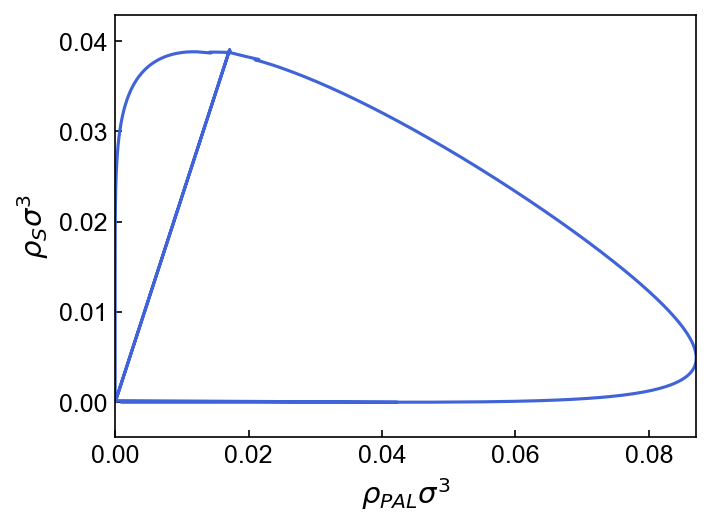

In [1158]:
plt.clf()
for j in 1:1
    
    idxend = Np
    # if Znet[j]==-8
    #     println(j)
    #     idxend -= 120
    # end
    X = vcat(ρ[j,1:idxend,1],reverse(ρ[j,1:idxend,4]))
    Y = vcat(ρ[j,1:idxend,3],reverse(ρ[j,1:idxend,6]))
    plt.plot(X,Y,label="")
end
# plt.text(0.115,0.045,L"l_B/\sigma=1.0",fontsize=12)
# plt.text(0.115,0.04,L"\chi=0",fontsize=12)
# plt.text(0.075,0.03,L"Z_{net}=-2",color="C0")
# plt.text(0.04,0.015,L"Z_{net}=-8",color="C3")
# plt.annotate("", xy=(0.06, 0.018), xytext=(0.08, 0.027), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))

plt.xlabel(L"\rho_{PAL}\sigma^3")
plt.ylabel(L"\rho_{S}\sigma^3")
# plt.xlim(0,0.15)
# plt.ylim(0,0.05)
# plt.savefig("figures/phaseq_neut_salt.pdf",dpi=DPI)
# plt.savefig("figures/test.png",dpi=DPI)

display(plt.gcf())

In [206]:
for j in 1:length(Znet)
    idxend = findfirst(ρ[j,:,1].==0)-2
    # X = vcat(ρ[j,1:idxend,1],reverse(ρ[j,1:idxend,4]))
    # Y = vcat(ρ[j,1:idxend,2],reverse(ρ[j,1:idxend,5]))
    CSV.write("data/pals_Nu_1_Znet_$(Znet[j])_salt.csv",  Tables.table(ρ[j,:,:]), writeheader=false)
end

# Critical Points

In [264]:
lB = 1.0

Nu = 1:60
ρc = zeros(length(Nu),2)
x0 = log10.([0.025,0.04])

for j in 1:length(Nu)
    println(j)
    model = LS(["PAL","C","A"]; userlocations=(;
                            N = [N,1,1],
                            Nu = [Nu[j],0,0],
                            Z = [0,1,-1]))

    obj!(F,x) = critObj_mix(F,model,lB,exp10.(x))

    x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
    x0 = Clapeyron.Solvers.x_sol(x)
    ρc[j,:] = exp10.(x0)
    if ρc[j,2] < 1e-3
        break
    end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [368]:
lB = 1.0

Znet = 0:-1:-37
Nu = 1:56
ρc = zeros(length(Nu),length(Znet),2)
x01 = log10.([0.025,0.04])
for i in 1:length(Nu)
    println("Nu = ",Nu[i])
    model = LS(["PAL","C","A"]; userlocations=(;
                                N = [N,1,1],
                                Nu = [Nu[i],0,0],
                                Z = [0,1,-1]))
    obj!(F,x) = critObj_mix(F,model,lB,exp10.(x))

    x = Clapeyron.Solvers.nlsolve(obj!,big.(x01))
    x01 = Clapeyron.Solvers.x_sol(x)
    ρc[i,1,:] = exp10.(x01)

    x02 = deepcopy(x01)

    for j in 2:length(Znet)
        # println(j)
        model = LS(["PAL","C","A"]; userlocations=(;
                                N = [N,1,1],
                                Nu = [Nu[i],0,0],
                                Z = [Znet[j],1,-1]))

        obj!(F,x) = critObj_mix(F,model,lB,exp10.(x))

        x = Clapeyron.Solvers.nlsolve(obj!,big.(x02))
        x02 = Clapeyron.Solvers.x_sol(x)
        ρc[i,j,:] = exp10.(x02)
        if ρc[i,j,2] < 1e-3
            break
        end
    end
end

Nu = 1
Nu = 2
Nu = 3
Nu = 4
Nu = 5
Nu = 6
Nu = 7
Nu = 8
Nu = 9
Nu = 10
Nu = 11
Nu = 12
Nu = 13
Nu = 14
Nu = 15
Nu = 16
Nu = 17
Nu = 18
Nu = 19
Nu = 20
Nu = 21
Nu = 22
Nu = 23
Nu = 24
Nu = 25
Nu = 26
Nu = 27
Nu = 28
Nu = 29
Nu = 30
Nu = 31
Nu = 32
Nu = 33
Nu = 34
Nu = 35
Nu = 36
Nu = 37
Nu = 38
Nu = 39
Nu = 40
Nu = 41
Nu = 42
Nu = 43
Nu = 44
Nu = 45
Nu = 46
Nu = 47
Nu = 48
Nu = 49
Nu = 50
Nu = 51
Nu = 52
Nu = 53
Nu = 54
Nu = 55


SingularException: SingularException(2)

In [811]:
lB = 1.0
Znet = -36:1:0
Nu = 1:56
# ρc2 = zeros(length(Nu),length(Znet),2)


for i in 55:length(Nu)
    println("Nu = ",Nu[i])
    x0 = log10.([0.0035,0.00045])
    idxstart = findlast(reverse(ρc[i,:,1]).>=0.05)
    if isnothing(idxstart) || idxstart == 1
        idxstart = 32
    else
        idxstart += 1
    end
    println(Znet[idxstart])
    for j in idxstart:length(Znet)
        println(j)
        model = LS(["PAL","C","A"]; userlocations=(;
                                N = [N,1,1],
                                Nu = [Nu[i],0,0],
                                Z = [Znet[j],1,-1]))

        obj!(F,x) = critObj_mix(F,model,lB,exp10.(x))

        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρc2[i,j,:] = exp10.(x0)
        if j-idxstart <= 30
            x0 .-= log10(2)
        end
        # println(x0)
        if ρc2[i,j,2] < 1e-4
            break
        end
    end
end

Nu = 55
-5
32
33
34
35
36


InterruptException: InterruptException:

In [814]:
A = zeros(length(Nu)*length(Znet),4)

for i in 1:length(Nu)
    A[(i-1)*length(Znet)+1:i*length(Znet),1] .= Nu[i]
    A[(i-1)*length(Znet)+1:i*length(Znet),2] .= Znet
    A[(i-1)*length(Znet)+1:i*length(Znet),3:4] .= ρc2[i,:,:]
end
CSV.write("data/pals_crit_salt_LCST.csv",  Tables.table(A), writeheader=false)

"data/pals_crit_salt_LCST.csv"

# Plots

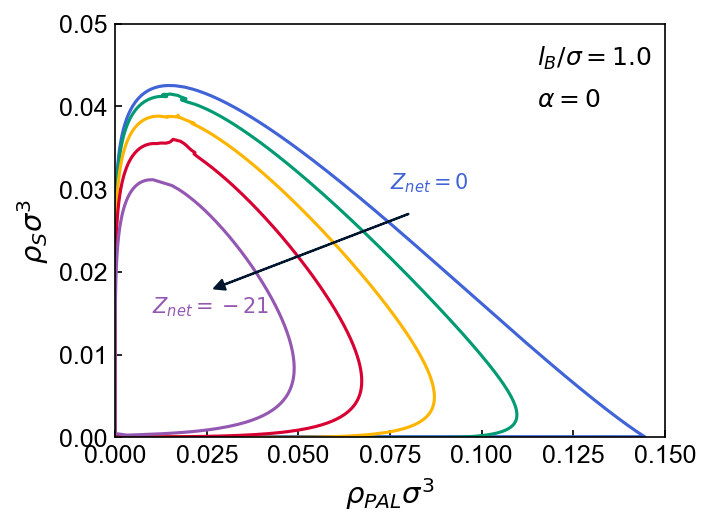

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [1179]:
Znet = [0,-6,-11,-16,-21]
Nu = 1

plt.clf()
for j in 1:length(Znet)
    ρ = CSV.read("data/pals_Nu_$(Nu)_Znet_$(Znet[j])_salt.csv",Tables.matrix)
    idxend = findfirst(ρ[:,1].==0)
    if isnothing(idxend)
        idxend = size(ρ,1)
    else
        idxend -= 2
    end
    X = vcat(ρ[1:idxend,1],reverse(ρ[1:idxend,4]),ρ[1,1])
    Y = vcat(ρ[1:idxend,3],reverse(ρ[1:idxend,6]),ρ[1,3])
    plt.plot(X,Y,label="")
end
plt.text(0.115,0.045,L"l_B/\sigma=1.0",fontsize=12)
plt.text(0.115,0.04,L"\alpha=0",fontsize=12)
plt.text(0.075,0.03,L"Z_{net}=0",color="C0",fontsize=10)
plt.text(0.01,0.015,L"Z_{net}=-21",color="C4",fontsize=10)
plt.annotate("", xy=(0.027, 0.018), xytext=(0.08, 0.027), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))

plt.xlabel(L"\rho_{PAL}\sigma^3")
plt.ylabel(L"\rho_{S}\sigma^3")
plt.xlim(0,0.15)
plt.ylim(0,0.05)
plt.savefig("figures/phaseq_chrg_salt.pdf",dpi=DPI)
plt.savefig("figures/phaseq_chrg_salt.png",dpi=DPI)
display(plt.gcf())

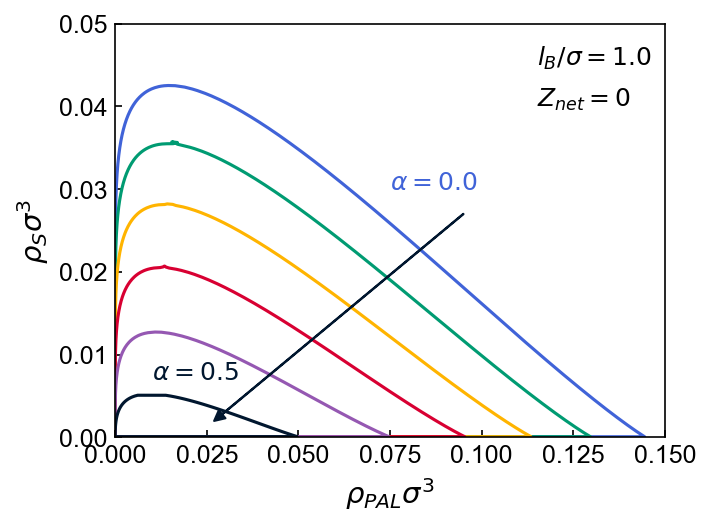

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [1178]:
Znet = 0
Nu = [1,11,21,31,41,51]

plt.clf()
for j in 1:length(Nu)
    ρ = CSV.read("data/pals_Nu_$(Nu[j])_Znet_$(Znet)_salt.csv",Tables.matrix)
    idxend = findfirst(ρ[:,1].==0)
    if isnothing(idxend)
        idxend = size(ρ,1)
    else
        idxend -= 2
    end
    X = vcat(ρ[1:idxend,1],reverse(ρ[1:idxend,4]),ρ[1,1])
    Y = vcat(ρ[1:idxend,3],reverse(ρ[1:idxend,6]),ρ[1,3])
    plt.plot(X,Y,label="")
end

plt.text(0.115,0.045,L"l_B/\sigma=1.0",fontsize=12)
plt.text(0.115,0.04,L"Z_{net}=0",fontsize=12)
plt.text(0.075,0.03,L"\alpha=0.0",color="C0")
plt.text(0.01,0.007,L"\alpha=0.5",color="C5")
plt.annotate("", xy=(0.027, 0.002), xytext=(0.095, 0.027), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))

plt.xlabel(L"\rho_{PAL}\sigma^3")
plt.ylabel(L"\rho_{S}\sigma^3")
plt.xlim(0,0.15)
plt.ylim(0,0.05)
plt.savefig("figures/phaseq_neut_salt.pdf",dpi=DPI)
plt.savefig("figures/phaseq_neut_salt.png",dpi=DPI)
display(plt.gcf())

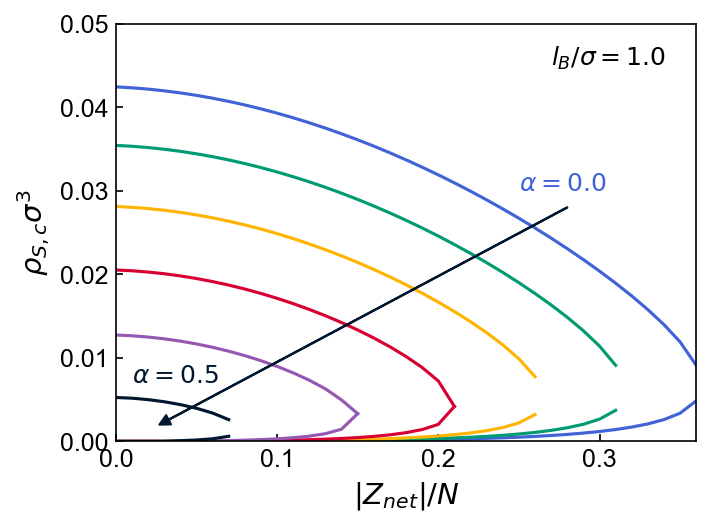

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [1176]:
plt.clf()
Znet = -36:0
Nu = 1:10:51

ρU = CSV.read("data/pals_crit_salt_UCST.csv",Tables.matrix, header=false)
ρL = CSV.read("data/pals_crit_salt_LCST.csv",Tables.matrix, header=false)
idxend = [1,6,11,16,22,30]
for j in 1:length(Nu)
    A = zeros(length(Znet),4)
    for i in 1:length(Znet)
        A[i,1:2] = ρU[ρU[:,1].==Nu[j] .&& ρU[:,2].==Znet[i],3:4]
        A[i,3:4] = ρL[ρL[:,1].==Nu[j] .&& ρL[:,2].==Znet[i],3:4]
        
    end
    plt.plot(abs.(Znet[idxend[j]:end])/100,A[idxend[j]:end,2],label="UCST",color="C"*string(j-1))
    plt.plot(abs.(Znet[idxend[j]:end])/100,A[idxend[j]:end,4],label="LCST",color="C"*string(j-1))
end
plt.text(0.27,0.045,L"l_B/\sigma=1.0",fontsize=12)
plt.text(0.25,0.03,L"\alpha=0.0",color="C0")
plt.text(0.01,0.007,L"\alpha=0.5",color="C5")
plt.annotate("", xy=(0.027, 0.002), xytext=(0.28, 0.028), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
plt.xlabel(L"|Z_{net}|/N")
plt.ylabel(L"\rho_{S,c}\sigma^3")
plt.ylim(0,0.05)
plt.savefig("crit_chrg_salt.pdf")
plt.savefig("crit_chrg_salt.png")
display(plt.gcf())